# Weed detection and localisation 

CNN model for detection and localisation of weed in image

### TODO : Future aspects

- [ ] Convert model to onnx format
- [ ] Try out different architectures and compare performance and select best one without compromising tradeoff between True negetives and false positives

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import glob
from torch.utils.data import Dataset,DataLoader,random_split
from PIL import Image
import torchvision
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

jpegs = glob.glob('/content/drive/MyDrive/Crop Dataset/agri_data/data/*.jpeg')
txts = [i.rsplit('.',maxsplit=1)[0]+'.txt' for i in jpegs]

In [3]:
jpegs[0]

'/content/drive/MyDrive/Crop Dataset/agri_data/data/agri_0_600.jpeg'

In [4]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
class GenData(Dataset):
    def __init__(self,jpegs,txts,transformer):
        self.jpegs = jpegs
        self.txts = txts
        self.transformer = transformer
    def __getitem__(self, item):
        img = Image.open(jpegs[item]).convert('RGB')
        img = transformer(img)
        df = pd.read_csv(txts[item], header=None, sep=' ')
        df.columns = ['label', 'x_cen', 'y_cen', 'w', 'h']
        df['xmin'] = (df['x_cen'] - df['w'] / 2) * 512
        df['ymin'] = (df['y_cen'] - df['h'] / 2) * 512
        df['xmax'] = (df['x_cen'] + df['w'] / 2) * 512
        df['ymax'] = (df['y_cen'] + df['h'] / 2) * 512
        bbox = np.array(df.iloc[:,5:]).tolist()
        label = np.array(df.iloc[:, 0]).squeeze().tolist()
        bbox = torch.tensor(bbox,dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.int64).reshape(-1,)
        target = {}
        target['boxes'] = bbox
        target['labels'] = label
        return img,target
    def __len__(self):
        return len(self.jpegs)

dataset = GenData(jpegs,txts,transformer)
train_len = int(dataset.__len__()*0.7)
test_len = int(dataset.__len__()-train_len)
dataset_train,dataset_test = random_split(dataset,[train_len,test_len])

def detection_collate(x):
    return list(tuple(zip(*x)))
dl_train = DataLoader(dataset_train,1,shuffle=True,collate_fn=detection_collate)
dl_test = DataLoader(dataset_test,1,shuffle=True,collate_fn=detection_collate)

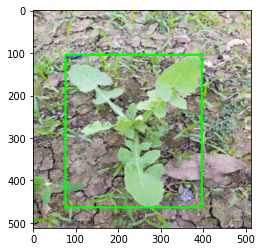

In [6]:
class_idx1={0:'crop',1:'weed'}
def train_img_show(dl_train,class_idx1):
    img,label = next(iter(dl_train))

    img_sample = np.transpose(np.array(img[0]),(1,2,0))*255
    img_sample = img_sample.astype(np.uint8)
    img_sample = img_sample.copy()
    box1 = label[0]['boxes'].numpy()
    label1 = label[0]['labels'].numpy()

    for i in range(len(label1)):
        x1,y1,x2,y2 = int(box1[i][0]),int(box1[i][1]),int(box1[i][2]),int(box1[i][3])
        label = str(class_idx1[label1[i]])
        cv2.rectangle(img_sample,(x1,y1),(x2,y2),(0,255,0),3)
        cv2.putText(img_sample,text=label,fontScale=0.5,fontFace=cv2.FONT_HERSHEY_SIMPLEX,thickness=1,lineType=cv2.LINE_AA,color=(0,0,255),org=(x1,y1+10))
    plt.imshow(img_sample)
train_img_show(dl_train,class_idx1)

In [7]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=3)
model=model.to('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer=torch.optim.Adam(params,lr=0.0001)
loss_list = []

def train_one_epoch(model, optimizer, dl_train, dl_test, device, epochs):
    for epoch in range(epochs):
        loss_epoch = []
        iou_epoch = []
        for images, targets in tqdm(dl_train):
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                loss_epoch.append(losses.cpu().numpy())
                label = targets
                try:
                    pred = model(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        iou_epoch.append(iou_total)

                except:
                    continue
        test_loss_epoch = []
        test_iou_epoch = []
        gc.collect()
        torch.cuda.empty_cache()
        for images, targets in tqdm(dl_test):
            model.train()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            with torch.no_grad():
                model.eval()
                test_loss_epoch.append(losses.cpu().numpy())
                label = list(targets)
                try:
                    pred = model(images)
                    for i in range(len(pred)):
                        pic_boxes = pred[i]['boxes']
                        label_boxes = label[i]['boxes']
                        iou_tensor = torchvision.ops.box_iou(label_boxes, pic_boxes)
                        iou_total = np.mean(torch.max(iou_tensor, dim=1)[0].cpu().numpy())
                        test_iou_epoch.append(iou_total)

                except:
                    continue

        mIou = np.mean(iou_epoch)
        epochloss = np.mean(loss_epoch)
        test_mIou = np.mean(test_iou_epoch)
        test_epochloss = np.mean(test_loss_epoch)
        static_dict = model.state_dict()
        torch.save(static_dict,'./{}test_mIou_{}test_loss{}.pth'.format(epoch,round(test_mIou,3),round(test_epochloss,3)))

        print('\n',
              'epoch:', epoch,
              'epoch_mIou:', mIou,
              'epoch_loss:', epochloss,
              'test_epoch_mIou:', test_mIou,
              'test_epoch_loss:', test_epochloss)
        gc.collect()
        torch.cuda.empty_cache()


train_one_epoch(model, optimizer, dl_train,dl_test, 'cuda', 15)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

100%|██████████| 391/391 [01:12<00:00,  5.40it/s]



 epoch: 0 epoch_mIou: 0.6496414 epoch_loss: 0.17675921 test_epoch_mIou: 0.68135405 test_epoch_loss: 0.16683312


100%|██████████| 391/391 [01:12<00:00,  5.39it/s]



 epoch: 1 epoch_mIou: 0.69819504 epoch_loss: 0.13225658 test_epoch_mIou: 0.6543329 test_epoch_loss: 0.15410256


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]



 epoch: 2 epoch_mIou: 0.7032168 epoch_loss: 0.13229558 test_epoch_mIou: 0.70902777 test_epoch_loss: 0.11852276


100%|██████████| 391/391 [01:12<00:00,  5.39it/s]



 epoch: 3 epoch_mIou: 0.7114939 epoch_loss: 0.11312665 test_epoch_mIou: 0.6921988 test_epoch_loss: 0.11107851


100%|██████████| 391/391 [01:12<00:00,  5.42it/s]



 epoch: 4 epoch_mIou: 0.7101903 epoch_loss: 0.11817379 test_epoch_mIou: 0.7250045 test_epoch_loss: 0.11954561


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]



 epoch: 5 epoch_mIou: 0.7233265 epoch_loss: 0.119153015 test_epoch_mIou: 0.64969903 test_epoch_loss: 0.10429332


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]



 epoch: 6 epoch_mIou: 0.7208533 epoch_loss: 0.1017151 test_epoch_mIou: 0.7236469 test_epoch_loss: 0.10304034


100%|██████████| 391/391 [01:12<00:00,  5.38it/s]



 epoch: 7 epoch_mIou: 0.74342936 epoch_loss: 0.09809543 test_epoch_mIou: 0.75618213 test_epoch_loss: 0.11004649


100%|██████████| 391/391 [01:12<00:00,  5.38it/s]



 epoch: 8 epoch_mIou: 0.7379692 epoch_loss: 0.09351635 test_epoch_mIou: 0.727016 test_epoch_loss: 0.09717623


100%|██████████| 391/391 [01:12<00:00,  5.37it/s]



 epoch: 9 epoch_mIou: 0.7599426 epoch_loss: 0.07733224 test_epoch_mIou: 0.72659993 test_epoch_loss: 0.09873221


100%|██████████| 391/391 [01:13<00:00,  5.32it/s]



 epoch: 10 epoch_mIou: 0.75840473 epoch_loss: 0.074473426 test_epoch_mIou: 0.6850631 test_epoch_loss: 0.10704637


100%|██████████| 391/391 [01:12<00:00,  5.38it/s]



 epoch: 11 epoch_mIou: 0.76671153 epoch_loss: 0.07457072 test_epoch_mIou: 0.7375315 test_epoch_loss: 0.10243292


100%|██████████| 391/391 [01:13<00:00,  5.35it/s]



 epoch: 12 epoch_mIou: 0.7713577 epoch_loss: 0.068689115 test_epoch_mIou: 0.7384152 test_epoch_loss: 0.11234904


100%|██████████| 391/391 [01:13<00:00,  5.31it/s]



 epoch: 13 epoch_mIou: 0.7816962 epoch_loss: 0.06585573 test_epoch_mIou: 0.669375 test_epoch_loss: 0.103794195


100%|██████████| 391/391 [01:13<00:00,  5.32it/s]



 epoch: 14 epoch_mIou: 0.8020046 epoch_loss: 0.05687108 test_epoch_mIou: 0.71677184 test_epoch_loss: 0.10606511


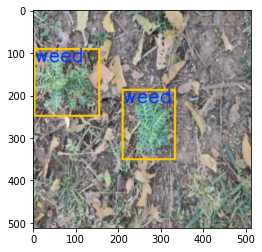

In [28]:
model.eval()
names = {'0': 'crop', '1': 'weed'}
src_img = plt.imread(r"/content/drive/MyDrive/Crop Dataset/agri_data/data/agri_0_377.jpeg")
img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float().cuda()

out = model(torch.unsqueeze(img_tensor,dim=0))
boxes = out[0]['boxes'].cpu().detach().numpy().astype(int)
labels = out[0]['labels'].cpu().detach().numpy()
scores = out[0]['scores'].cpu().detach().numpy()
for idx in range(boxes.shape[0]):
    if scores[idx] >= 0.8:
        x1, y1, x2, y2 = boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3]
        name = names.get(str(labels[idx].item()))
        cv2.rectangle(src_img,(x1,y1),(x2,y2),(255,200,0),thickness=3)
        cv2.putText(src_img, text=name, org=(x1, y1+30), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.5, thickness=2, lineType=cv2.LINE_AA, color=(0,50, 255))

plt.imshow(src_img)
